In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# Data paths
csv_path = "/Users/architmurgudkar/Documents/MDSI/ILAB/SkinCapDataFolder/skincap_v240623.csv"
img_dir = "/Users/architmurgudkar/Documents/MDSI/ILAB/SkinCapDataFolder/skincap"

# Data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['skincap_file_path']
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image: {img_path}")
            print(f"Error details: {str(e)}")
            image = torch.zeros((3, 224, 224))
        
        return image, img_name

class SkinLesionEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=1280):
        super(SkinLesionEmbeddingModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.efficientnet.classifier = nn.Identity()  # Remove the final classification layer
        self.embedding_layer = nn.Linear(1280, embedding_dim)
    
    def forward(self, x):
        features = self.efficientnet(x)
        embedding = self.embedding_layer(features)
        return embedding

def create_embedding_dataloader(df, img_dir, batch_size=32):
    dataset = SkinLesionDataset(df, img_dir, transform=data_transforms)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    filenames = []
    
    with torch.no_grad():
        for images, img_names in dataloader:
            images = images.to(device)
            batch_embeddings = model(images)
            embeddings.extend(batch_embeddings.cpu().numpy())
            filenames.extend(img_names)
    
    return np.array(embeddings), filenames

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Read CSV file
    df = pd.read_csv(csv_path)

    # Initialize the embedding model
    embedding_dim = 512  # You can adjust this value
    model = SkinLesionEmbeddingModel(embedding_dim=embedding_dim).to(device)

    # Create dataloader
    dataloader = create_embedding_dataloader(df, img_dir)

    # Extract embeddings
    embeddings, filenames = extract_embeddings(model, dataloader, device)

    # Save embeddings and filenames
    np.save('skin_lesion_embeddings.npy', embeddings)
    with open('skin_lesion_filenames.txt', 'w') as f:
        for filename in filenames:
            f.write(f"{filename}\n")

    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Number of files processed: {len(filenames)}")
    print("Embeddings and filenames saved successfully.")

if __name__ == "__main__":
    main()

Using device: cpu
Embeddings shape: (4000, 512)
Number of files processed: 4000
Embeddings and filenames saved successfully.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def load_embeddings_and_filenames(embeddings_path, filenames_path):
    embeddings = np.load(embeddings_path)
    with open(filenames_path, 'r') as f:
        filenames = [line.strip() for line in f]
    return embeddings, filenames

In [6]:
def visualize_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

In [7]:
def evaluate_clustering(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg}")
    
    return cluster_labels


In [8]:
def visualize_pca(embeddings, labels, title):
    pca = PCA(n_components=3)
    embeddings_3d = pca.fit_transform(embeddings)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

In [9]:
def plot_elbow_method(embeddings, max_clusters=20):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

In [10]:
def plot_embedding_heatmap(embeddings, n_samples=100):
    sample_indices = np.random.choice(embeddings.shape[0], n_samples, replace=False)
    sample_embeddings = embeddings[sample_indices]
    
    plt.figure(figsize=(12, 10))
    plt.imshow(sample_embeddings, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title('Heatmap of Sample Embeddings')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Sample Index')
    plt.show()


In [11]:
def analyze_embedding_distribution(embeddings):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.hist(embeddings.mean(axis=0), bins=50)
    plt.title('Distribution of Mean Embedding Values')
    plt.xlabel('Mean Value')
    plt.ylabel('Frequency')
    
    plt.subplot(122)
    plt.hist(embeddings.std(axis=0), bins=50)
    plt.title('Distribution of Embedding Standard Deviations')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


In [12]:
def dbscan_clustering(embeddings, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(embeddings)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    
    return cluster_labels

In [13]:
def plot_nearest_neighbor_distances(embeddings, k=5):
    nn = NearestNeighbors(n_neighbors=k+1)  # +1 because the first neighbor is the point itself
    nn.fit(embeddings)
    distances, _ = nn.kneighbors(embeddings)
    avg_distances = distances[:, 1:].mean(axis=1)  # Exclude the first column (distance to self)
    
    plt.figure(figsize=(10, 6))
    plt.hist(avg_distances, bins=50)
    plt.title(f'Distribution of Average Distance to {k} Nearest Neighbors')
    plt.xlabel('Average Distance')
    plt.ylabel('Frequency')
    plt.show()

In [14]:
def evaluate_similarity_search(embeddings, filenames, query_index, top_k=5):
    query_embedding = embeddings[query_index]
    distances = cdist([query_embedding], embeddings, metric='cosine')[0]
    
    top_indices = np.argsort(distances)[1:top_k+1]  # Exclude the query image itself
    top_similar = [(filenames[i], distances[i]) for i in top_indices]
    
    print(f"Query image: {filenames[query_index]}")
    print("Top similar images:")
    for filename, distance in top_similar:
        print(f"{filename}: cosine distance = {distance:.4f}")

/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.045489005744457245


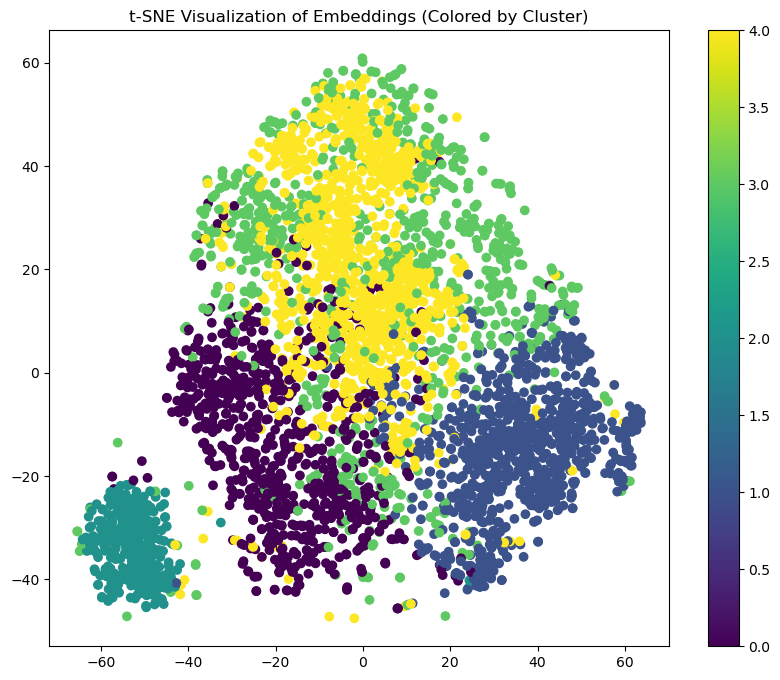

Query image: 1.png
Top similar images:
1665.png: cosine distance = 0.3078
839.png: cosine distance = 0.3974
3812.png: cosine distance = 0.4197
2108.png: cosine distance = 0.4298
3592.png: cosine distance = 0.4312


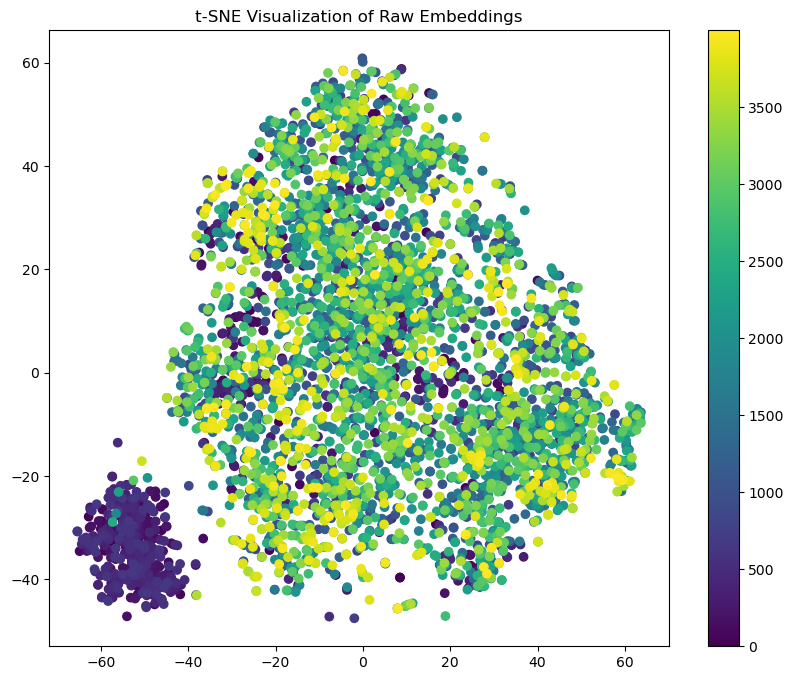

/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416:

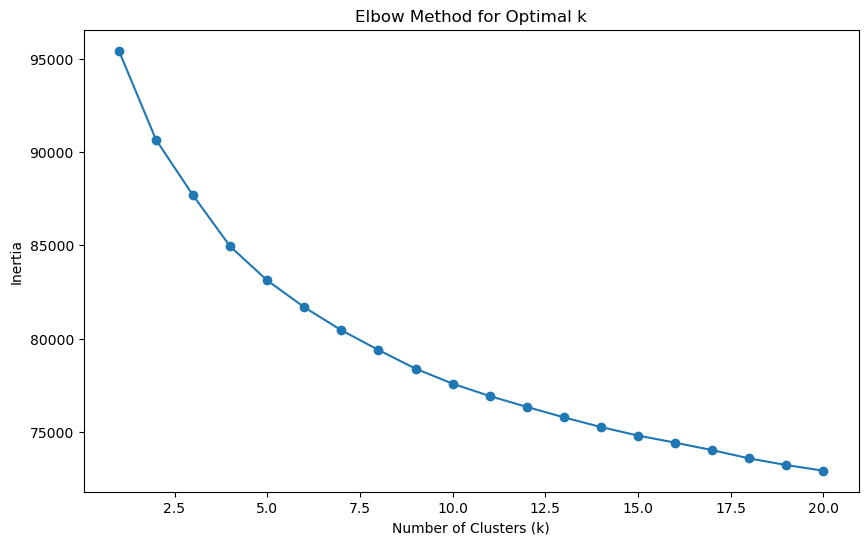

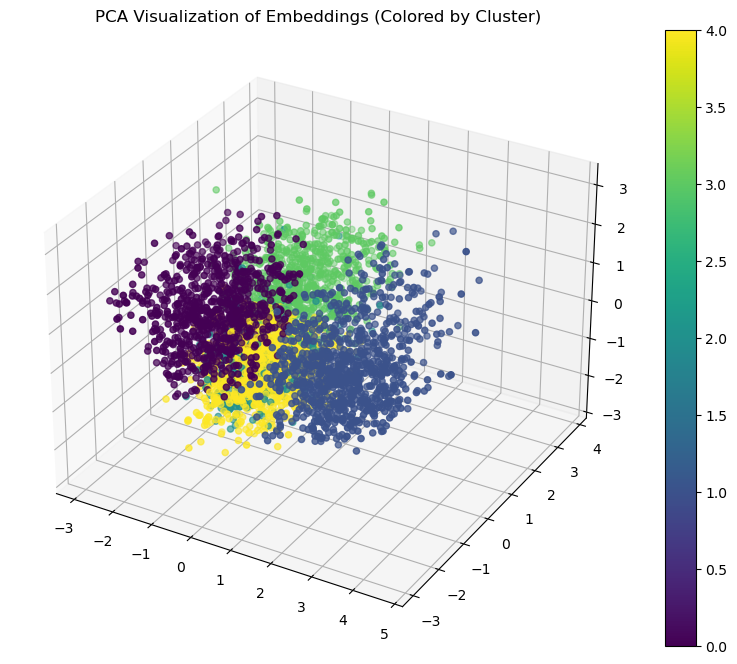

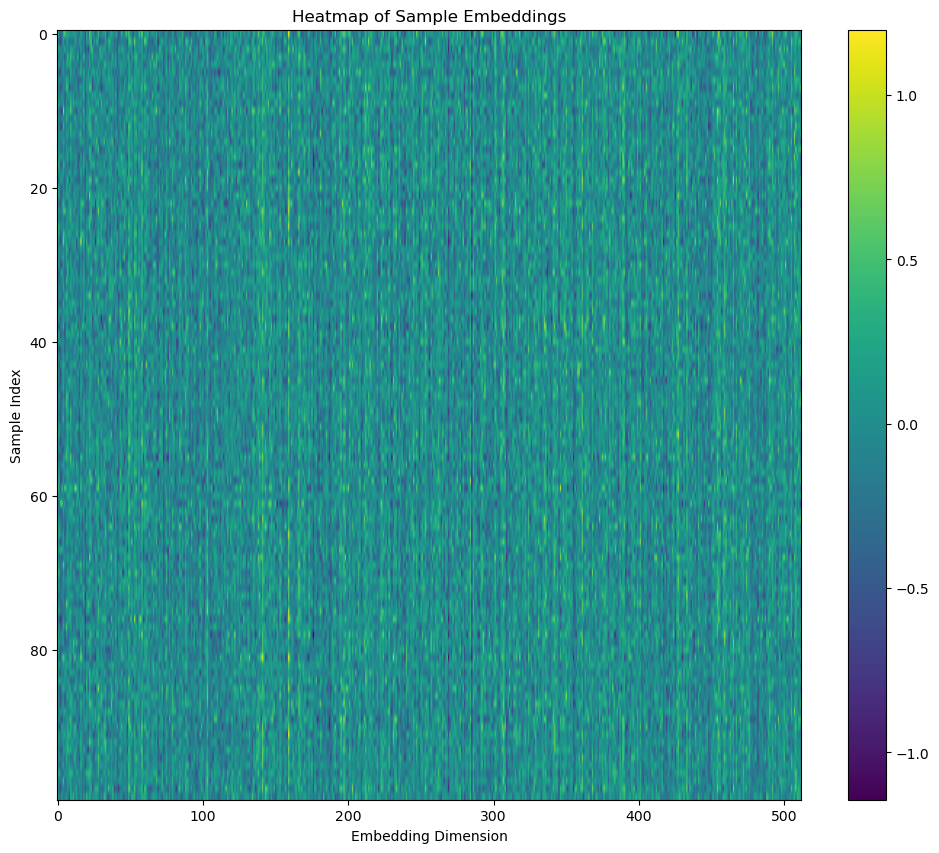

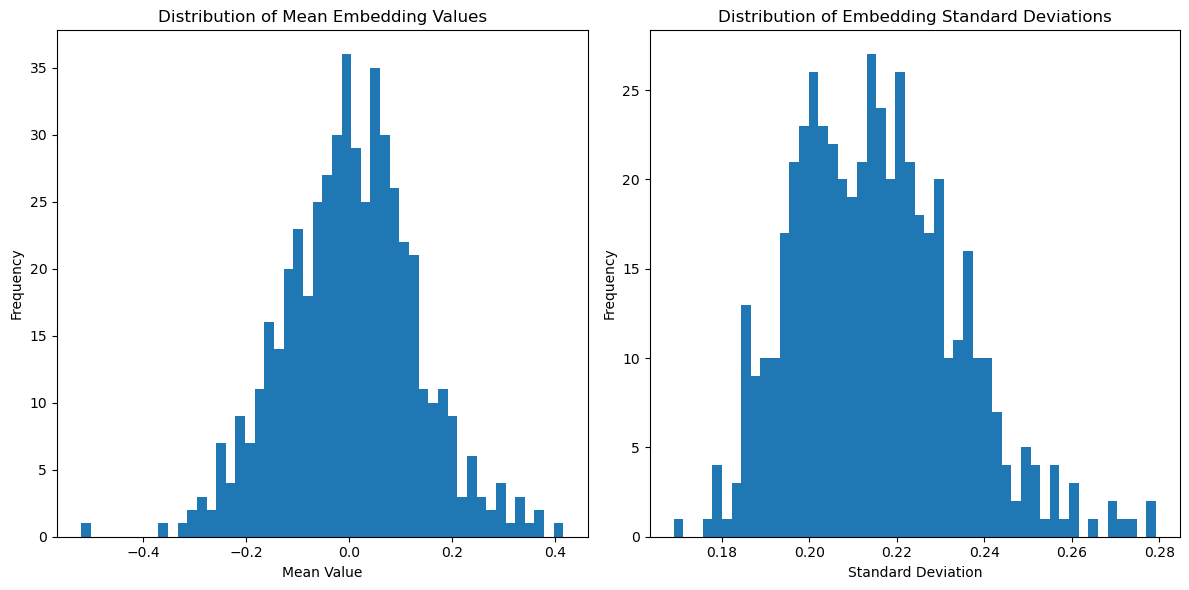

Number of clusters: 0
Number of noise points: 4000


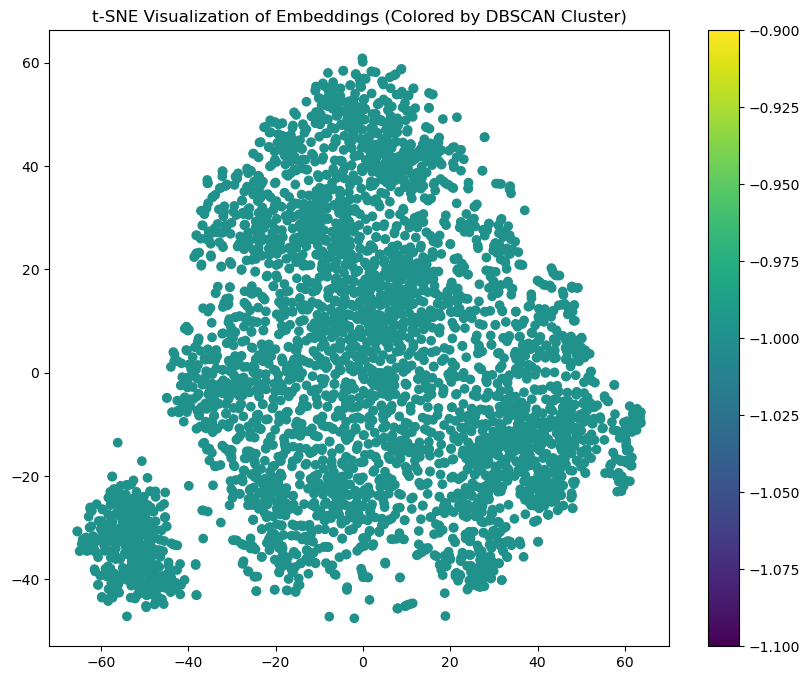

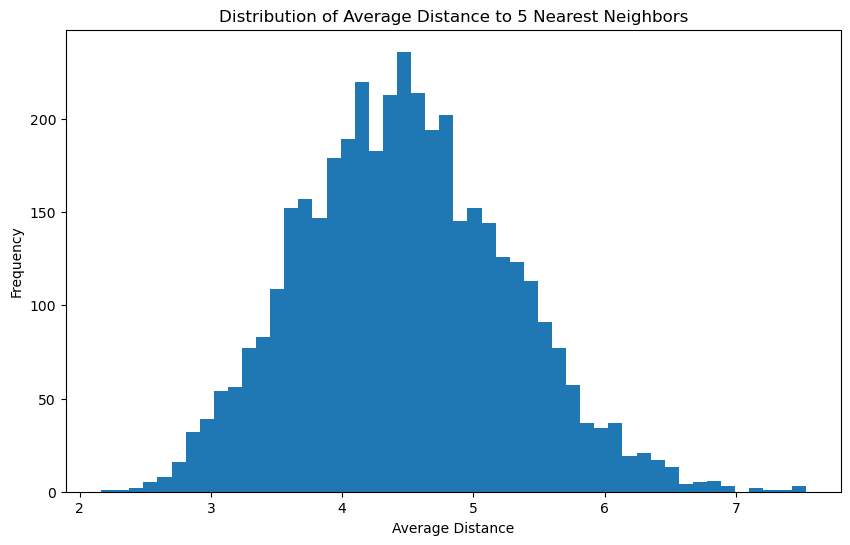

In [15]:
def main():
    embeddings_path = 'skin_lesion_embeddings.npy'
    filenames_path = 'skin_lesion_filenames.txt'
    
    embeddings, filenames = load_embeddings_and_filenames(embeddings_path, filenames_path)
    
    # Existing analyses
    cluster_labels = evaluate_clustering(embeddings)
    visualize_tsne(embeddings, cluster_labels, "t-SNE Visualization of Embeddings (Colored by Cluster)")
    query_index = 0
    evaluate_similarity_search(embeddings, filenames, query_index)
    visualize_tsne(embeddings, np.arange(len(embeddings)), "t-SNE Visualization of Raw Embeddings")
    
    # New analyses
    plot_elbow_method(embeddings)
    visualize_pca(embeddings, cluster_labels, "PCA Visualization of Embeddings (Colored by Cluster)")
    plot_embedding_heatmap(embeddings)
    analyze_embedding_distribution(embeddings)
    dbscan_labels = dbscan_clustering(embeddings)
    visualize_tsne(embeddings, dbscan_labels, "t-SNE Visualization of Embeddings (Colored by DBSCAN Cluster)")
    plot_nearest_neighbor_distances(embeddings)

if __name__ == "__main__":
    main()